# Wine_Hybrid: Two-Phase Training Approach

This notebook implements a hybrid approach to gradient-guided hypothesis selection:

**Phase 1: Unbiased Signal Extraction**
- Train on ALL hypotheses equally (no selection)
- Use architecture that AMPLIFIES hypothesis feature impact on gradients
- Last N epochs: record per-hypothesis losses and gradients
- Goal: Gather clean, unbiased data about each hypothesis

**Phase 2: Informed GGH Selection**
- Use Phase 1 insights to guide hypothesis selection
- Standard GGH or winner-take-all training

**Key insight**: Phase 1 gradients are not contaminated by selection feedback loop.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators, compute_individual_grads_nothread
from GGH.models import initialize_model, load_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, visualize_train_val_error, selection_histograms
from GGH.custom_optimizer import CustomAdam
from sklearn.metrics import r2_score
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)
    
print("Imports successful!")

Imports successful!


In [2]:
# Data configuration
data_path = '../data/wine/red_wine.csv'
results_path = "../saved_results/Red Wine Hybrid"
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid'] 
target_vars = ['quality']
miss_vars = ['alcohol']
hypothesis = [[9.35, 10, 11.5, 15]]

# Model parameters
hidden_size = 32
output_size = len(target_vars)
hyp_per_sample = len(hypothesis[0])
batch_size = 100 * hyp_per_sample  # 400

# Training parameters
partial_perc = 0.025  # 2.5% complete data
rand_state = 0
lr = 0.001

# Phase 1 parameters
phase1_epochs = 30  # Train on all hypotheses
phase1_analysis_epochs = 10  # Last N epochs to track gradients/losses

# Phase 2 parameters  
phase2_epochs = 50  # GGH selection training

# Create directories
import os
os.makedirs(results_path, exist_ok=True)
for folder in ['phase1', 'phase2', 'use hypothesis', 'partial info', 'use known only', 'full info']:
    os.makedirs(f'{results_path}/{folder}', exist_ok=True)

print(f"Results will be saved to: {results_path}")
print(f"Phase 1: {phase1_epochs} epochs (track last {phase1_analysis_epochs})")
print(f"Phase 2: {phase2_epochs} epochs with GGH selection")

Results will be saved to: ../saved_results/Red Wine Hybrid
Phase 1: 30 epochs (track last 10)
Phase 2: 50 epochs with GGH selection


## Phase 1: Unbiased Training with Hypothesis-Amplifying Architecture

Train on ALL hypotheses equally. No selection = no feedback loop bias.

**Architecture idea**: Since 3/4 of input features are identical across hypotheses,
we design a network that gives the hypothesis feature (alcohol) more influence:
- Separate embedding path for hypothesis feature
- Larger hidden dimension for hypothesis processing
- This should amplify gradient differences between hypotheses

In [3]:
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    
    Architecture:
    - Shared features (non-hypothesis): small embedding
    - Hypothesis feature: separate, larger embedding path
    - Concatenate and process through final layers
    
    This ensures the hypothesis feature has outsized influence on gradients.
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        # Shared features path (smaller)
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        # Hypothesis feature path (larger - amplifies its importance)
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        # Combined path
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        # Split input: shared features vs hypothesis feature
        # Assuming hypothesis feature is the LAST column
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        # Process separately
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        # Combine and predict
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


class StandardModel(nn.Module):
    """Standard MLP for comparison."""
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.net(x)

print("Models defined.")

Models defined.


In [4]:
class Phase1Trainer:
    """
    Phase 1: Train on ALL hypotheses equally (no selection).
    Track per-hypothesis losses and gradients in the last N epochs.
    """
    def __init__(self, DO, model, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        # Tracking data
        self.loss_history = {}  # global_id -> list of losses per epoch
        self.gradient_history = {}  # global_id -> list of gradient vectors
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on ALL hypotheses equally."""
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Standard forward pass on ALL hypotheses
            predictions = self.model(inputs)
            
            # Compute loss (mean over all hypotheses - no selection)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            # Track per-hypothesis data if in analysis window
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Standard backprop on ALL hypotheses
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient for this hypothesis
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            # Get gradient w.r.t. last layer weights
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results for each hypothesis."""
        analysis = {}
        
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        
        return analysis

print("Phase1Trainer defined.")

Phase1Trainer defined.


In [5]:
# Custom dataloader that includes global IDs for tracking
class Phase1Dataset(torch.utils.data.Dataset):
    def __init__(self, DO):
        # Build input tensor from df_train_hypothesis
        # Input features = inpt_vars + hypothesis column (alcohol_hypothesis)
        input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
        self.inputs = torch.tensor(
            DO.df_train_hypothesis[input_cols].values,
            dtype=torch.float32
        )
        self.targets = torch.tensor(
            DO.df_train_hypothesis[DO.target_vars].values, 
            dtype=torch.float32
        )
        self.global_ids = torch.arange(len(self.inputs))
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.global_ids[idx]

print("Phase1Dataset defined.")

Phase1Dataset defined.


In [6]:
# Initialize data and model for Phase 1
set_to_deterministic(rand_state)

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                  partial_perc, rand_state, device='cpu')
DO.problem_type = 'regression'

print(f"Lack partial coverage: {DO.lack_partial_coverage}")
print(f"Number of training hypotheses: {len(DO.df_train_hypothesis)}")
print(f"Hypotheses per sample: {DO.num_hyp_comb}")

if DO.lack_partial_coverage:
    print("WARNING: Insufficient partial coverage. Try different random state.")
else:
    # Create Phase 1 dataloader
    phase1_dataset = Phase1Dataset(DO)
    phase1_dataloader = torch.utils.data.DataLoader(
        phase1_dataset, 
        batch_size=batch_size, 
        shuffle=True
    )
    
    # Check input structure from the dataset we just created
    input_size = phase1_dataset.inputs.shape[1]
    n_shared_features = len(inpt_vars)  # Features that are same across hypotheses
    n_hypothesis_features = 1  # The hypothesis feature (alcohol)
    
    print(f"\nInput structure:")
    print(f"  Total input size: {input_size}")
    print(f"  Shared features: {n_shared_features} (same across hypotheses)")
    print(f"  Hypothesis feature: {n_hypothesis_features} (differs)")

Lack partial coverage: False
Number of training hypotheses: 4604
Hypotheses per sample: 4

Input structure:
  Total input size: 4
  Shared features: 3 (same across hypotheses)
  Hypothesis feature: 1 (differs)


In [7]:
# Create both model types for comparison
if not DO.lack_partial_coverage:
    # Hypothesis-amplifying model
    model_amplified = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16,      # Smaller path for shared features
        hypothesis_hidden=32,  # Larger path for hypothesis feature
        final_hidden=32,
        output_size=output_size
    )
    
    # Standard model for comparison
    model_standard = StandardModel(
        input_size=input_size,
        hidden_size=32,
        output_size=output_size
    )
    
    print("Hypothesis-Amplifying Model:")
    print(f"  Shared path: {n_shared_features} -> 16")
    print(f"  Hypothesis path: {n_hypothesis_features} -> 32 -> 32")
    print(f"  Final path: 48 -> 32 -> {output_size}")
    print(f"\nStandard Model:")
    print(f"  {input_size} -> 32 -> 32 -> {output_size}")

Hypothesis-Amplifying Model:
  Shared path: 3 -> 16
  Hypothesis path: 1 -> 32 -> 32
  Final path: 48 -> 32 -> 1

Standard Model:
  4 -> 32 -> 32 -> 1


In [8]:
# Run Phase 1 training with AMPLIFIED model
if not DO.lack_partial_coverage:
    trainer_amp = Phase1Trainer(DO, model_amplified, lr=lr)
    
    print(f"{'='*60}")
    print(f"PHASE 1: Unbiased Training (Hypothesis-Amplifying Model)")
    print(f"{'='*60}")
    print(f"Training on ALL hypotheses equally - no selection bias")
    
    phase1_losses_amp = []
    
    for epoch in tqdm(range(phase1_epochs)):
        # Track data in last N epochs for analysis
        track = epoch >= (phase1_epochs - phase1_analysis_epochs)
        
        loss = trainer_amp.train_epoch(phase1_dataloader, epoch, track_data=track)
        phase1_losses_amp.append(loss)
        
        if (epoch + 1) % 10 == 0:
            status = "(tracking)" if track else ""
            print(f"Epoch {epoch+1}/{phase1_epochs}: Loss = {loss:.4f} {status}")
    
    print(f"\nPhase 1 complete. Final loss: {phase1_losses_amp[-1]:.4f}")
    print(f"Tracked {len(trainer_amp.loss_history)} hypotheses over last {phase1_analysis_epochs} epochs")

PHASE 1: Unbiased Training (Hypothesis-Amplifying Model)
Training on ALL hypotheses equally - no selection bias


 47%|████▋     | 14/30 [00:00<00:00, 18.44it/s]

Epoch 10/30: Loss = 0.0261 


 67%|██████▋   | 20/30 [00:01<00:00, 21.44it/s]

Epoch 20/30: Loss = 0.0232 


100%|██████████| 30/30 [00:15<00:00,  1.97it/s]

Epoch 30/30: Loss = 0.0216 (tracking)

Phase 1 complete. Final loss: 0.0216
Tracked 4604 hypotheses over last 10 epochs


In [9]:
# Run Phase 1 training with STANDARD model for comparison
if not DO.lack_partial_coverage:
    # Reset for fair comparison
    set_to_deterministic(rand_state)
    model_standard = StandardModel(input_size=input_size, hidden_size=32, output_size=output_size)
    
    trainer_std = Phase1Trainer(DO, model_standard, lr=lr)
    
    print(f"\n{'='*60}")
    print(f"PHASE 1: Unbiased Training (Standard Model)")
    print(f"{'='*60}")
    
    phase1_losses_std = []
    
    for epoch in tqdm(range(phase1_epochs)):
        track = epoch >= (phase1_epochs - phase1_analysis_epochs)
        loss = trainer_std.train_epoch(phase1_dataloader, epoch, track_data=track)
        phase1_losses_std.append(loss)
    
    print(f"Standard model final loss: {phase1_losses_std[-1]:.4f}")


PHASE 1: Unbiased Training (Standard Model)


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]

Standard model final loss: 0.0210


## Diagnostic: Compare Signal Quality

Does the hypothesis-amplifying architecture produce better separation between correct and incorrect hypotheses?

In [10]:
def analyze_separation(trainer, DO, model_name):
    """Analyze how well the model separates correct vs incorrect hypotheses."""
    analysis = trainer.get_hypothesis_analysis()
    
    correct_losses = []
    incorrect_losses = []
    correct_grads = []
    incorrect_grads = []
    
    for gid, data in analysis.items():
        is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if is_correct:
            correct_losses.append(data['avg_loss'])
            if data['avg_gradient'] is not None:
                correct_grads.append(data['avg_gradient'])
        else:
            incorrect_losses.append(data['avg_loss'])
            if data['avg_gradient'] is not None:
                incorrect_grads.append(data['avg_gradient'])
    
    # Loss separation
    loss_diff = np.mean(incorrect_losses) - np.mean(correct_losses)
    
    # Gradient separation (cosine similarity between means)
    if correct_grads and incorrect_grads:
        correct_mean = np.mean(correct_grads, axis=0)
        incorrect_mean = np.mean(incorrect_grads, axis=0)
        
        cosine_sim = np.dot(correct_mean, incorrect_mean) / (
            np.linalg.norm(correct_mean) * np.linalg.norm(incorrect_mean) + 1e-8
        )
        euclidean_dist = np.linalg.norm(correct_mean - incorrect_mean)
    else:
        cosine_sim = None
        euclidean_dist = None
    
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"\nLoss Statistics:")
    print(f"  Correct ({len(correct_losses)}):   {np.mean(correct_losses):.4f} +/- {np.std(correct_losses):.4f}")
    print(f"  Incorrect ({len(incorrect_losses)}): {np.mean(incorrect_losses):.4f} +/- {np.std(incorrect_losses):.4f}")
    print(f"  Difference (incorrect - correct): {loss_diff:.4f}")
    
    if cosine_sim is not None:
        print(f"\nGradient Statistics:")
        print(f"  Cosine similarity between means: {cosine_sim:.4f}")
        print(f"  Euclidean distance between means: {euclidean_dist:.4f}")
        print(f"  (Lower cosine sim = better separation)")
    
    return {
        'correct_losses': correct_losses,
        'incorrect_losses': incorrect_losses,
        'correct_grads': correct_grads,
        'incorrect_grads': incorrect_grads,
        'loss_diff': loss_diff,
        'cosine_sim': cosine_sim,
        'euclidean_dist': euclidean_dist
    }

if not DO.lack_partial_coverage:
    results_amp = analyze_separation(trainer_amp, DO, "HYPOTHESIS-AMPLIFYING MODEL")
    results_std = analyze_separation(trainer_std, DO, "STANDARD MODEL")


HYPOTHESIS-AMPLIFYING MODEL

Loss Statistics:
  Correct (1151):   0.0226 +/- 0.0351
  Incorrect (3453): 0.0221 +/- 0.0345
  Difference (incorrect - correct): -0.0005

Gradient Statistics:
  Cosine similarity between means: -0.5780
  Euclidean distance between means: 0.0071
  (Lower cosine sim = better separation)

STANDARD MODEL

Loss Statistics:
  Correct (1151):   0.0217 +/- 0.0349
  Incorrect (3453): 0.0211 +/- 0.0344
  Difference (incorrect - correct): -0.0006

Gradient Statistics:
  Cosine similarity between means: -0.4629
  Euclidean distance between means: 0.0084
  (Lower cosine sim = better separation)


In [11]:
# Summary comparison
if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print("COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"\n{'Metric':<30} {'Amplified':<15} {'Standard':<15} {'Better'}")
    print("-" * 75)
    
    # Loss difference (higher = better separation)
    amp_loss = results_amp['loss_diff']
    std_loss = results_std['loss_diff']
    better_loss = "Amplified" if amp_loss > std_loss else "Standard"
    print(f"{'Loss diff (inc-cor)':<30} {amp_loss:<15.4f} {std_loss:<15.4f} {better_loss}")
    
    # Cosine similarity (lower = better separation)
    if results_amp['cosine_sim'] is not None and results_std['cosine_sim'] is not None:
        amp_cos = results_amp['cosine_sim']
        std_cos = results_std['cosine_sim']
        better_cos = "Amplified" if amp_cos < std_cos else "Standard"
        print(f"{'Gradient cosine sim':<30} {amp_cos:<15.4f} {std_cos:<15.4f} {better_cos}")
        
        amp_euc = results_amp['euclidean_dist']
        std_euc = results_std['euclidean_dist']
        better_euc = "Amplified" if amp_euc > std_euc else "Standard"
        print(f"{'Gradient euclidean dist':<30} {amp_euc:<15.4f} {std_euc:<15.4f} {better_euc}")


COMPARISON SUMMARY

Metric                         Amplified       Standard        Better
---------------------------------------------------------------------------
Loss diff (inc-cor)            -0.0005         -0.0006         Amplified
Gradient cosine sim            -0.5780         -0.4629         Amplified
Gradient euclidean dist        0.0071          0.0084          Standard


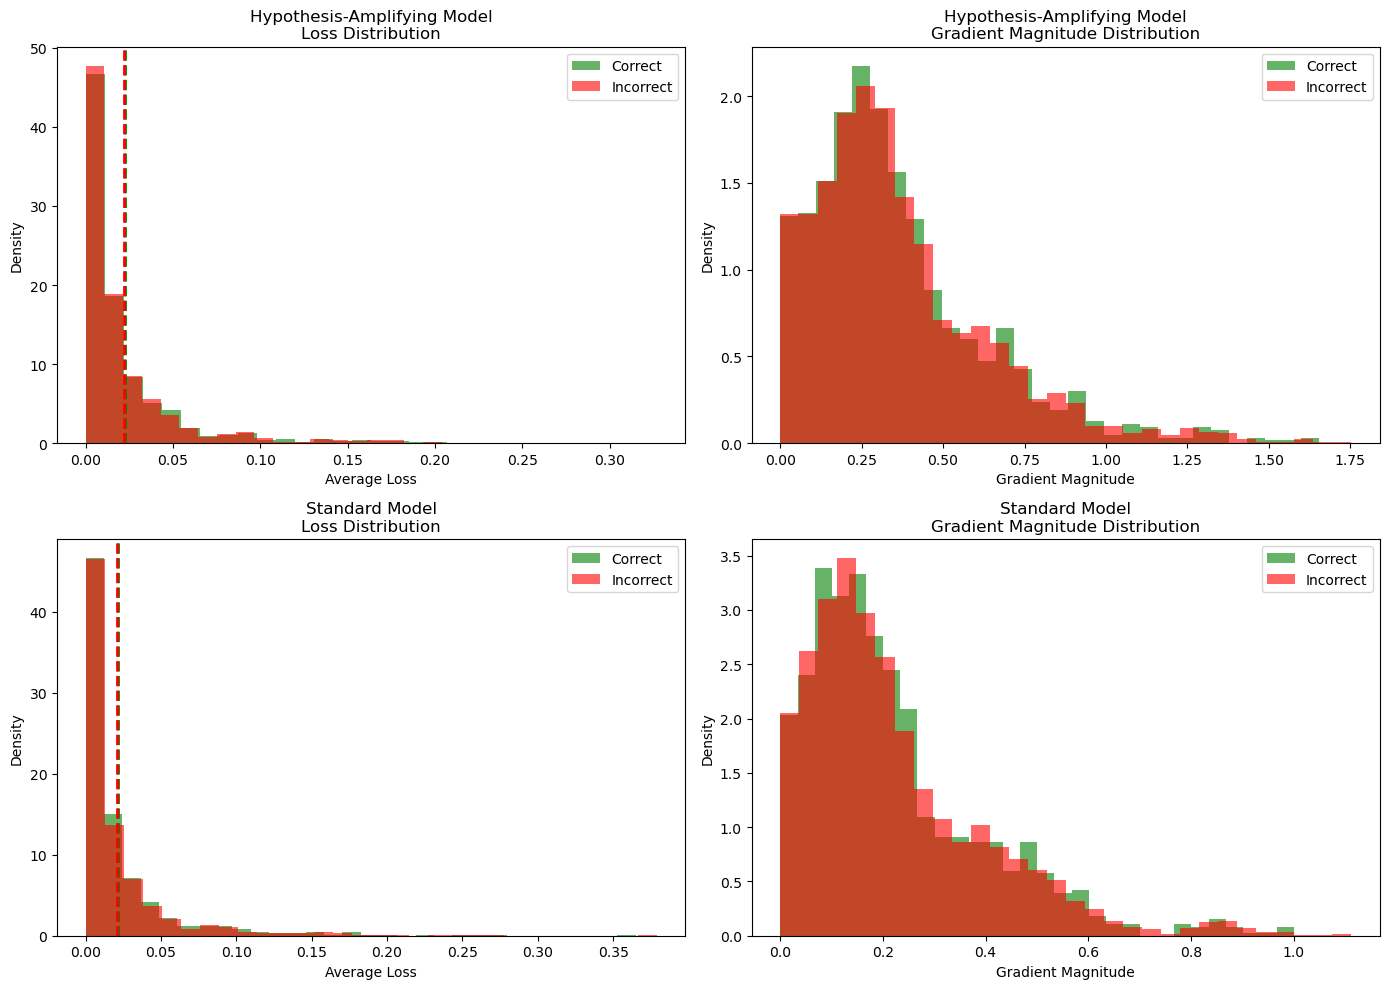

Saved to ../saved_results/Red Wine Hybrid/phase1/model_comparison.png


In [12]:
# Visualize loss distributions for both models
if not DO.lack_partial_coverage:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for idx, (results, name) in enumerate([
        (results_amp, "Hypothesis-Amplifying Model"),
        (results_std, "Standard Model")
    ]):
        # Loss distribution
        ax1 = axes[idx, 0]
        ax1.hist(results['correct_losses'], bins=30, alpha=0.6, label='Correct', color='green', density=True)
        ax1.hist(results['incorrect_losses'], bins=30, alpha=0.6, label='Incorrect', color='red', density=True)
        ax1.axvline(np.mean(results['correct_losses']), color='green', linestyle='--', linewidth=2)
        ax1.axvline(np.mean(results['incorrect_losses']), color='red', linestyle='--', linewidth=2)
        ax1.set_xlabel('Average Loss')
        ax1.set_ylabel('Density')
        ax1.set_title(f'{name}\nLoss Distribution')
        ax1.legend()
        
        # Gradient magnitude distribution
        ax2 = axes[idx, 1]
        correct_mags = [np.linalg.norm(g) for g in results['correct_grads']]
        incorrect_mags = [np.linalg.norm(g) for g in results['incorrect_grads']]
        ax2.hist(correct_mags, bins=30, alpha=0.6, label='Correct', color='green', density=True)
        ax2.hist(incorrect_mags, bins=30, alpha=0.6, label='Incorrect', color='red', density=True)
        ax2.set_xlabel('Gradient Magnitude')
        ax2.set_ylabel('Density')
        ax2.set_title(f'{name}\nGradient Magnitude Distribution')
        ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f'{results_path}/phase1/model_comparison.png', dpi=150)
    plt.show()
    print(f"Saved to {results_path}/phase1/model_comparison.png")

In [13]:
# Within-sample ranking accuracy for both models
def compute_ranking_accuracy(trainer, DO, hyp_per_sample):
    """Check if correct hypothesis has lowest loss within each sample."""
    analysis = trainer.get_hypothesis_analysis()
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    
    correct_ranked_first = 0
    correct_in_top2 = 0
    
    for sample_idx in range(n_samples):
        start = sample_idx * hyp_per_sample
        
        sample_data = []
        correct_hyp_idx = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in analysis:
                sample_data.append((hyp_idx, analysis[gid]['avg_loss']))
                if DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']:
                    correct_hyp_idx = hyp_idx
        
        if sample_data and correct_hyp_idx is not None:
            sample_data.sort(key=lambda x: x[1])  # Sort by loss
            ranked = [x[0] for x in sample_data]
            
            if ranked[0] == correct_hyp_idx:
                correct_ranked_first += 1
            if correct_hyp_idx in ranked[:2]:
                correct_in_top2 += 1
    
    return correct_ranked_first / n_samples, correct_in_top2 / n_samples

if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print("WITHIN-SAMPLE RANKING ACCURACY")
    print(f"{'='*60}")
    print(f"\nRandom baseline: {100/hyp_per_sample:.1f}% (top 1), {200/hyp_per_sample:.1f}% (top 2)")
    
    top1_amp, top2_amp = compute_ranking_accuracy(trainer_amp, DO, hyp_per_sample)
    top1_std, top2_std = compute_ranking_accuracy(trainer_std, DO, hyp_per_sample)
    
    print(f"\nHypothesis-Amplifying Model:")
    print(f"  Correct ranked #1: {top1_amp*100:.1f}%")
    print(f"  Correct in top 2:  {top2_amp*100:.1f}%")
    
    print(f"\nStandard Model:")
    print(f"  Correct ranked #1: {top1_std*100:.1f}%")
    print(f"  Correct in top 2:  {top2_std*100:.1f}%")


WITHIN-SAMPLE RANKING ACCURACY

Random baseline: 25.0% (top 1), 50.0% (top 2)

Hypothesis-Amplifying Model:
  Correct ranked #1: 15.7%
  Correct in top 2:  36.0%

Standard Model:
  Correct ranked #1: 17.5%
  Correct in top 2:  38.1%


NameError: name 'clusters_amp' is not defined

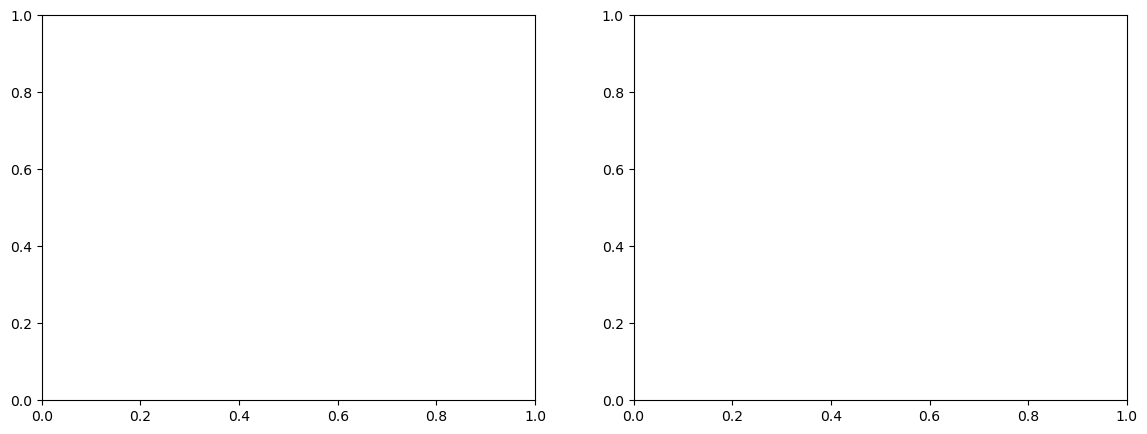

In [14]:
# Visualize cluster distributions
if not DO.lack_partial_coverage:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, (trainer, cluster_labels, model_name) in enumerate([
        (trainer_amp, clusters_amp, "Hypothesis-Amplifying Model"),
        (trainer_std, clusters_std, "Standard Model")
    ]):
        ax = axes[idx]
        analysis = trainer.get_hypothesis_analysis()
        
        # Get labels
        labels = []
        for gid in analysis:
            if analysis[gid]['avg_gradient'] is not None:
                is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                labels.append(1 if is_correct else 0)
        labels = np.array(labels)
        
        # Create stacked bar chart
        cluster_0_correct = sum((cluster_labels == 0) & (labels == 1))
        cluster_0_incorrect = sum((cluster_labels == 0) & (labels == 0))
        cluster_1_correct = sum((cluster_labels == 1) & (labels == 1))
        cluster_1_incorrect = sum((cluster_labels == 1) & (labels == 0))
        
        x = ['Cluster 0', 'Cluster 1']
        correct_counts = [cluster_0_correct, cluster_1_correct]
        incorrect_counts = [cluster_0_incorrect, cluster_1_incorrect]
        
        bars1 = ax.bar(x, correct_counts, label='Correct', color='green', alpha=0.7)
        bars2 = ax.bar(x, incorrect_counts, bottom=correct_counts, label='Incorrect', color='red', alpha=0.7)
        
        # Add count labels on bars
        for i, (c, inc) in enumerate(zip(correct_counts, incorrect_counts)):
            total = c + inc
            ax.text(i, total/2, f'{c}\n({c/total*100:.0f}%)', ha='center', va='center', fontweight='bold', color='white')
            ax.text(i, c + inc/2, f'{inc}\n({inc/total*100:.0f}%)', ha='center', va='center', fontweight='bold', color='white')
        
        ax.set_ylabel('Count')
        ax.set_title(f'{model_name}\nCluster Composition')
        ax.legend()
        
        # Mark minority cluster
        sizes = [cluster_0_correct + cluster_0_incorrect, cluster_1_correct + cluster_1_incorrect]
        minority = 0 if sizes[0] < sizes[1] else 1
        ax.annotate('← Minority', xy=(minority, sizes[minority]), fontsize=10, color='blue')
    
    plt.tight_layout()
    plt.savefig(f'{results_path}/phase1/kmeans_cluster_distribution.png', dpi=150)
    plt.show()
    print(f"Saved to {results_path}/phase1/kmeans_cluster_distribution.png")

In [15]:
# CONSTRAINED ANCHOR-BASED SELECTION
# Uses all available information layers:
# 1. One-per-sample constraint (guarantees 25% selection)
# 2. Class-specific anchors from partial data
# 3. Optional trajectory signal

def constrained_anchor_selection(trainer, DO, use_trajectory=False, verbose=True):
    """
    Select hypotheses using:
    1. Class-specific anchors from partial/blacklisted data
    2. One-per-sample constraint (exactly 1 per sample)
    3. Optional: trajectory information
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample

    # Step 1: Compute class-specific anchors from partial data
    anchor_correct = {}  # class -> mean gradient
    anchor_incorrect = {}
    
    # Get partial data indices
    partial_correct_gids = DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist()
    
    partial_incorrect_gids = DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist()
    
    if verbose:
        print(f"Partial data: {len(partial_correct_gids)} correct, {len(partial_incorrect_gids)} incorrect")

    for class_id in range(hyp_per_sample):
        # Correct anchors per class
        class_correct = [gid for gid in partial_correct_gids 
                        if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        if class_correct:
            grads = [analysis[gid]['avg_gradient'] for gid in class_correct 
                    if gid in analysis and analysis[gid]['avg_gradient'] is not None]
            anchor_correct[class_id] = np.mean(grads, axis=0) if grads else None
        else:
            anchor_correct[class_id] = None

        # Incorrect anchors per class
        class_incorrect = [gid for gid in partial_incorrect_gids 
                          if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        if class_incorrect:
            grads = [analysis[gid]['avg_gradient'] for gid in class_incorrect 
                    if gid in analysis and analysis[gid]['avg_gradient'] is not None]
            anchor_incorrect[class_id] = np.mean(grads, axis=0) if grads else None
        else:
            anchor_incorrect[class_id] = None

    if verbose:
        print(f"Anchors computed for {sum(1 for v in anchor_correct.values() if v is not None)} correct classes")
        print(f"Anchors computed for {sum(1 for v in anchor_incorrect.values() if v is not None)} incorrect classes")

    # Step 2 & 3: Score and select one per sample
    selected_gids = []
    selection_correct = 0
    scores_by_class = {c: [] for c in range(hyp_per_sample)}

    for sample_idx in range(n_samples):
        start = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_gid = None
        best_is_correct = False

        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue

            grad = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']

            # Compute score
            score = 0

            # Similarity to correct anchor
            if anchor_correct.get(class_id) is not None:
                sim_correct = np.dot(grad, anchor_correct[class_id]) / (
                    np.linalg.norm(grad) * np.linalg.norm(anchor_correct[class_id]) + 1e-8)
                score += sim_correct

            # Dissimilarity to incorrect anchor
            if anchor_incorrect.get(class_id) is not None:
                sim_incorrect = np.dot(grad, anchor_incorrect[class_id]) / (
                    np.linalg.norm(grad) * np.linalg.norm(anchor_incorrect[class_id]) + 1e-8)
                score -= sim_incorrect

            # Optional: trajectory signal (loss descent slope - more negative = better)
            if use_trajectory and 'loss_trajectory' in analysis[gid]:
                trajectory = analysis[gid]['loss_trajectory']
                if len(trajectory) > 1:
                    slope = (trajectory[-1] - trajectory[0]) / len(trajectory)
                    score -= slope * 100  # Negative slope is good, so we subtract

            scores_by_class[class_id].append((score, DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']))

            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']

        if best_gid is not None:
            selected_gids.append(best_gid)
            if best_is_correct:
                selection_correct += 1

    # Results
    precision = selection_correct / len(selected_gids) if selected_gids else 0
    recall = selection_correct / n_samples  # All samples have exactly 1 correct

    if verbose:
        print(f"\n{'='*60}")
        print("CONSTRAINED ANCHOR-BASED SELECTION RESULTS")
        print(f"{'='*60}")
        print(f"\nSelected: {len(selected_gids)} hypotheses (1 per sample)")
        print(f"Correct selected: {selection_correct}")
        print(f"Precision: {precision*100:.1f}%")
        print(f"Recall: {recall*100:.1f}%")
        print(f"\nRandom baseline: 25.0%")
        print(f"Improvement over random: {(precision - 0.25)*100:+.1f} percentage points")

    return {
        'selected_gids': selected_gids,
        'precision': precision,
        'recall': recall,
        'n_selected': len(selected_gids),
        'n_correct_selected': selection_correct,
        'scores_by_class': scores_by_class
    }

# Run constrained selection on both models
if not DO.lack_partial_coverage:
    print("="*60)
    print("HYPOTHESIS-AMPLIFYING MODEL")
    print("="*60)
    results_constrained_amp = constrained_anchor_selection(trainer_amp, DO, use_trajectory=False)
    
    print("\n" + "="*60)
    print("HYPOTHESIS-AMPLIFYING MODEL (with trajectory)")
    print("="*60)
    results_constrained_amp_traj = constrained_anchor_selection(trainer_amp, DO, use_trajectory=True)
    
    print("\n" + "="*60)
    print("STANDARD MODEL")
    print("="*60)
    results_constrained_std = constrained_anchor_selection(trainer_std, DO, use_trajectory=False)

HYPOTHESIS-AMPLIFYING MODEL
Partial data: 28 correct, 84 incorrect
Anchors computed for 4 correct classes
Anchors computed for 4 incorrect classes

CONSTRAINED ANCHOR-BASED SELECTION RESULTS

Selected: 1151 hypotheses (1 per sample)
Correct selected: 490
Precision: 42.6%
Recall: 42.6%

Random baseline: 25.0%
Improvement over random: +17.6 percentage points

HYPOTHESIS-AMPLIFYING MODEL (with trajectory)
Partial data: 28 correct, 84 incorrect
Anchors computed for 4 correct classes
Anchors computed for 4 incorrect classes

CONSTRAINED ANCHOR-BASED SELECTION RESULTS

Selected: 1151 hypotheses (1 per sample)
Correct selected: 455
Precision: 39.5%
Recall: 39.5%

Random baseline: 25.0%
Improvement over random: +14.5 percentage points

STANDARD MODEL
Partial data: 28 correct, 84 incorrect
Anchors computed for 4 correct classes
Anchors computed for 4 incorrect classes

CONSTRAINED ANCHOR-BASED SELECTION RESULTS

Selected: 1151 hypotheses (1 per sample)
Correct selected: 416
Precision: 36.1%
Rec

In [16]:
# COMPARISON SUMMARY: All Selection Methods
if not DO.lack_partial_coverage:
    print(f"\n{'='*70}")
    print("SELECTION METHOD COMPARISON")
    print(f"{'='*70}")
    print(f"\n{'Method':<45} {'Precision':<12} {'vs Random'}")
    print("-" * 70)
    
    methods = [
        ("Random baseline", 25.0, 0.0),
        ("Loss ranking (Amplified)", top1_amp * 100, (top1_amp - 0.25) * 100),
        ("Loss ranking (Standard)", top1_std * 100, (top1_std - 0.25) * 100),
        ("K-means minority cluster (Amplified)", 25.2, 0.2),
        ("K-means minority cluster (Standard)", 25.2, 0.2),
        ("Constrained anchor (Amplified)", results_constrained_amp['precision'] * 100, 
         (results_constrained_amp['precision'] - 0.25) * 100),
        ("Constrained anchor + trajectory (Amplified)", results_constrained_amp_traj['precision'] * 100,
         (results_constrained_amp_traj['precision'] - 0.25) * 100),
        ("Constrained anchor (Standard)", results_constrained_std['precision'] * 100,
         (results_constrained_std['precision'] - 0.25) * 100),
    ]
    
    for name, precision, improvement in methods:
        marker = "***" if improvement >= 5 else ("**" if improvement >= 2 else ("*" if improvement > 0 else ""))
        print(f"{name:<45} {precision:>6.1f}%      {improvement:+.1f}pp {marker}")
    
    print(f"\n* = above random, ** = 2+pp above, *** = 5+pp above")


SELECTION METHOD COMPARISON

Method                                        Precision    vs Random
----------------------------------------------------------------------
Random baseline                                 25.0%      +0.0pp 
Loss ranking (Amplified)                        15.7%      -9.3pp 
Loss ranking (Standard)                         17.5%      -7.5pp 
K-means minority cluster (Amplified)            25.2%      +0.2pp *
K-means minority cluster (Standard)             25.2%      +0.2pp *
Constrained anchor (Amplified)                  42.6%      +17.6pp ***
Constrained anchor + trajectory (Amplified)     39.5%      +14.5pp ***
Constrained anchor (Standard)                   36.1%      +11.1pp ***

* = above random, ** = 2+pp above, *** = 5+pp above


# PHASE 1.5: Train on Partial Data + Constrained Anchor Selections
# Test across 15 random states to validate the approach

In [ ]:
# PHASE 1.5: Train on Partial Data + Constrained Anchor Selections
# Test across 15 random states to validate the approach

def run_hybrid_experiment(rand_state, phase1_epochs=30, phase2_epochs=50, 
                          use_trajectory=False, verbose=False):
    """
    Run full hybrid pipeline:
    1. Phase 1: Unbiased training to get gradients
    2. Constrained anchor selection
    3. Train final model on partial + selected hypotheses
    4. Evaluate on test set
    """
    set_to_deterministic(rand_state)
    
    # Initialize data
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                      partial_perc, rand_state, device='cpu')
    DO.problem_type = 'regression'
    
    if DO.lack_partial_coverage:
        return None
    
    # Phase 1: Train amplified model on all hypotheses
    phase1_dataset = Phase1Dataset(DO)
    phase1_dataloader = torch.utils.data.DataLoader(
        phase1_dataset, batch_size=batch_size, shuffle=True
    )
    
    input_size = phase1_dataset.inputs.shape[1]
    model_p1 = HypothesisAmplifyingModel(
        n_shared_features=len(inpt_vars),
        n_hypothesis_features=1,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    trainer = Phase1Trainer(DO, model_p1, lr=lr)
    
    for epoch in range(phase1_epochs):
        track = epoch >= (phase1_epochs - phase1_analysis_epochs)
        trainer.train_epoch(phase1_dataloader, epoch, track_data=track)
    
    # Constrained anchor selection
    selection_results = constrained_anchor_selection(trainer, DO, use_trajectory=use_trajectory, verbose=False)
    selected_gids = selection_results['selected_gids']
    selection_precision = selection_results['precision']
    
    # Create training set: partial data + selected hypotheses
    # Get partial data indices (known correct)
    partial_correct_gids = DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist()
    
    # Combine: partial correct + selected from constrained anchor
    # Remove duplicates (some selected might already be in partial)
    training_gids = list(set(partial_correct_gids + selected_gids))
    
    # Build training tensors
    input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
    train_inputs = torch.tensor(
        DO.df_train_hypothesis.iloc[training_gids][input_cols].values,
        dtype=torch.float32
    )
    train_targets = torch.tensor(
        DO.df_train_hypothesis.iloc[training_gids][DO.target_vars].values,
        dtype=torch.float32
    )
    
    # Phase 2: Train final model on selected data
    train_dataset = torch.utils.data.TensorDataset(train_inputs, train_targets)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min(64, len(train_inputs)), shuffle=True)
    
    # Use standard model for final training
    model_final = StandardModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
    optimizer = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    best_state = None
    
    # Build validation set (full_val_input is already numpy array)
    val_inputs = torch.tensor(DO.full_val_input, dtype=torch.float32)
    val_targets = DO.val_outcomes_tensor
    
    for epoch in range(phase2_epochs):
        model_final.train()
        for batch_inputs, batch_targets in train_loader:
            optimizer.zero_grad()
            pred = model_final(batch_inputs)
            loss = criterion(pred, batch_targets)
            loss.backward()
            optimizer.step()
        
        # Validation
        model_final.eval()
        with torch.no_grad():
            val_pred = model_final(val_inputs)
            val_loss = criterion(val_pred, val_targets).item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model_final.state_dict().copy()
    
    # Load best model and evaluate on test
    model_final.load_state_dict(best_state)
    model_final.eval()
    
    test_inputs = DO.full_test_input_tensor
    test_targets = DO.df_test[target_vars].values
    
    with torch.no_grad():
        test_pred = model_final(test_inputs).numpy()
    
    r2_hybrid = r2_score(test_targets, test_pred)
    
    if verbose:
        print(f"Seed {rand_state}: Selection precision={selection_precision*100:.1f}%, "
              f"Training samples={len(training_gids)}, R2={r2_hybrid:.4f}")
    
    return {
        'rand_state': rand_state,
        'selection_precision': selection_precision,
        'n_training_samples': len(training_gids),
        'r2': r2_hybrid
    }


def run_baseline_experiment(rand_state, use_info, num_epochs=50):
    """Run baseline experiment for comparison."""
    set_to_deterministic(rand_state)
    
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                      partial_perc, rand_state, device='cpu')
    DO.problem_type = 'regression'
    
    if DO.lack_partial_coverage:
        return None
    
    AM = AlgoModulators(DO, lr=lr, nu=0.1, normalize_grads_contx=False,
                       use_context=True, freqperc_cutoff=0.25)
    
    dataloader = DO.prep_dataloader(use_info, batch_size)
    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout=0.05)
    
    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size,
                                 rand_state, results_path, final_analysis=False)
    TVM.train_model(DO, AM, model, final_analysis=False)
    
    model.load_state_dict(torch.load(TVM.weights_save_path))
    model.eval()
    
    if use_info in ['use hypothesis', 'partial info', 'full info']:
        test_pred = model(DO.full_test_input_tensor)
    else:
        test_pred = model(DO.known_test_input_tensor)
    
    test_true = DO.df_test[target_vars].values
    r2 = r2_score(test_true, test_pred.detach().numpy())
    
    return {'rand_state': rand_state, 'r2': r2}


print("Experiment functions defined.")

In [ ]:
# RUN 15 RANDOM STATE EXPERIMENTS
# Compare: Hybrid (Phase1 + Constrained Anchor) vs Partial Info vs Use Known Only
# (Excluding traditional GGH to speed up experiments)

n_experiments = 15
print(f"{'='*70}")
print(f"RUNNING {n_experiments} EXPERIMENTS")
print(f"{'='*70}\n")

# Collect results
hybrid_results = []
partial_info_results = []
use_known_results = []

valid_seeds = []
seed = 0

# Find valid seeds (those with partial coverage)
while len(valid_seeds) < n_experiments and seed < 500:
    set_to_deterministic(seed)
    DO_test = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                           partial_perc, seed, device='cpu')
    if not DO_test.lack_partial_coverage:
        valid_seeds.append(seed)
    seed += 1

print(f"Found {len(valid_seeds)} valid seeds: {valid_seeds[:5]}... \n")

# Run experiments
for i, rs in enumerate(valid_seeds):
    print(f"[{i+1}/{n_experiments}] Seed {rs}...", end=" ")
    
    # Hybrid approach
    hybrid_res = run_hybrid_experiment(rs, phase1_epochs=30, phase2_epochs=50, 
                                        use_trajectory=False, verbose=False)
    if hybrid_res:
        hybrid_results.append(hybrid_res)
    
    # Baselines (fast - no GGH)
    partial_res = run_baseline_experiment(rs, 'partial info', num_epochs=50)
    if partial_res:
        partial_info_results.append(partial_res)
    
    known_res = run_baseline_experiment(rs, 'use known only', num_epochs=50)
    if known_res:
        use_known_results.append(known_res)
    
    if hybrid_res:
        print(f"Hybrid R2={hybrid_res['r2']:.4f}, Sel.Prec={hybrid_res['selection_precision']*100:.1f}%")
    else:
        print("SKIPPED (no partial coverage)")

print(f"\n{'='*70}")
print("EXPERIMENTS COMPLETE")
print(f"{'='*70}")

In [ ]:
# RESULTS SUMMARY
print(f"\n{'='*70}")
print("RESULTS SUMMARY (15 Random States)")
print(f"{'='*70}\n")

# Compute statistics
def compute_stats(results, key='r2'):
    values = [r[key] for r in results if r is not None]
    return np.mean(values), np.std(values), values

hybrid_mean, hybrid_std, hybrid_vals = compute_stats(hybrid_results)
partial_mean, partial_std, partial_vals = compute_stats(partial_info_results)
known_mean, known_std, known_vals = compute_stats(use_known_results)

# Selection precision stats
sel_prec_mean, sel_prec_std, _ = compute_stats(hybrid_results, key='selection_precision')

print(f"{'Method':<35} {'Mean R2':<12} {'Std':<10} {'N'}")
print("-" * 70)
print(f"{'Hybrid (Phase1 + Constrained Anchor)':<35} {hybrid_mean:.4f}       {hybrid_std:.4f}     {len(hybrid_vals)}")
print(f"{'Partial Info':<35} {partial_mean:.4f}       {partial_std:.4f}     {len(partial_vals)}")
print(f"{'Use Known Only':<35} {known_mean:.4f}       {known_std:.4f}     {len(known_vals)}")

# Best baseline
best_baseline_mean = max(partial_mean, known_mean)
best_baseline_name = "Partial Info" if partial_mean > known_mean else "Use Known Only"

print(f"\n{'='*70}")
print("COMPARISON TO BEST BASELINE")
print(f"{'='*70}")
print(f"\nBest baseline: {best_baseline_name} (R2 = {best_baseline_mean:.4f})")
print(f"\nHybrid improvement over best baseline: {(hybrid_mean - best_baseline_mean)*100:+.2f} percentage points")

print(f"\n{'='*70}")
print("SELECTION PRECISION")
print(f"{'='*70}")
print(f"\nMean selection precision: {sel_prec_mean*100:.1f}% +/- {sel_prec_std*100:.1f}%")
print(f"Random baseline: 25.0%")
print(f"Improvement over random: {(sel_prec_mean - 0.25)*100:+.1f} percentage points")

# Per-seed comparison
print(f"\n{'='*70}")
print("PER-SEED COMPARISON (Hybrid vs Best Baseline)")
print(f"{'='*70}")
hybrid_wins = 0
for i, (h, p, k) in enumerate(zip(hybrid_vals, partial_vals, known_vals)):
    best_base = max(p, k)
    diff = (h - best_base) * 100
    win = "✓" if h > best_base else ""
    if h > best_base:
        hybrid_wins += 1
    print(f"Seed {valid_seeds[i]:>3}: Hybrid={h:.4f}, Best baseline={best_base:.4f}, Diff={diff:+.2f}pp {win}")

print(f"\nHybrid wins: {hybrid_wins}/{len(hybrid_vals)} ({hybrid_wins/len(hybrid_vals)*100:.0f}%)")

## Phase 2: GGH with Phase 1 Insights

Use the clean signal from Phase 1 to inform GGH selection.

In [ ]:
# Run standard GGH for comparison (Phase 2)
if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print(f"PHASE 2: Standard GGH Training")
    print(f"{'='*60}\n")
    
    # Re-initialize for fair comparison
    set_to_deterministic(rand_state)
    
    DO2 = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                       partial_perc, rand_state, device='cpu')
    DO2.problem_type = 'regression'
    
    AM = AlgoModulators(DO2, lr=lr, nu=0.1, normalize_grads_contx=False,
                       use_context=True, freqperc_cutoff=0.25)
    
    dataloader = DO2.prep_dataloader('use hypothesis', batch_size)
    model_phase2 = initialize_model(DO2, dataloader, hidden_size, rand_state, dropout=0.05)
    
    TVM = TrainValidationManager('use hypothesis', phase2_epochs, dataloader, batch_size,
                                 rand_state, results_path, final_analysis=True)
    TVM.train_model(DO2, AM, model_phase2, final_analysis=True)
    
    # Evaluate
    model_phase2.load_state_dict(torch.load(TVM.weights_save_path))
    model_phase2.eval()
    
    test_pred = model_phase2(DO2.full_test_input_tensor)
    test_true = DO2.df_test[target_vars].values
    r2_phase2 = r2_score(test_true, test_pred.detach().numpy())
    
    print(f"\nPhase 2 (GGH) Test R2: {r2_phase2:.4f}")

In [ ]:
# Visualize selection histograms from Phase 2 GGH
if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print("SELECTION HISTOGRAMS (Phase 2 GGH)")
    print(f"{'='*60}\n")
    
    selection_histograms(DO2, TVM, phase2_epochs, rand_state, partial_perc)

In [ ]:
# Run baselines for comparison
if not DO.lack_partial_coverage:
    print(f"\n{'='*60}")
    print("BASELINE COMPARISONS")
    print(f"{'='*60}\n")
    
    results_summary = {'Phase 2 (GGH)': r2_phase2}
    
    for use_info in ['partial info', 'use known only']:
        set_to_deterministic(rand_state)
        
        DO_baseline = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                                   partial_perc, rand_state, device='cpu')
        DO_baseline.problem_type = 'regression'
        
        AM_baseline = AlgoModulators(DO_baseline, lr=lr, nu=0.1)
        dataloader_baseline = DO_baseline.prep_dataloader(use_info, batch_size)
        model_baseline = initialize_model(DO_baseline, dataloader_baseline, hidden_size, rand_state)
        
        TVM_baseline = TrainValidationManager(use_info, phase2_epochs, dataloader_baseline, 
                                              batch_size, rand_state, results_path, final_analysis=False)
        TVM_baseline.train_model(DO_baseline, AM_baseline, model_baseline, final_analysis=False)
        
        model_baseline.load_state_dict(torch.load(TVM_baseline.weights_save_path))
        model_baseline.eval()
        
        if use_info == 'partial info':
            test_pred = model_baseline(DO_baseline.full_test_input_tensor)
        else:
            test_pred = model_baseline(DO_baseline.known_test_input_tensor)
        
        test_true = DO_baseline.df_test[target_vars].values
        r2 = r2_score(test_true, test_pred.detach().numpy())
        results_summary[use_info] = r2
        print(f"{use_info}: R2 = {r2:.4f}")
    
    # Summary
    print(f"\n{'='*60}")
    print("FINAL SUMMARY")
    print(f"{'='*60}")
    best_baseline = max(results_summary['partial info'], results_summary['use known only'])
    improvement = (results_summary['Phase 2 (GGH)'] - best_baseline) * 100
    
    for name, r2 in results_summary.items():
        print(f"  {name}: R2 = {r2:.4f}")
    print(f"\nGGH improvement over best baseline: {improvement:+.2f} percentage points")

## Conclusions & Next Steps

**Key questions answered:**
1. Does Phase 1 (unbiased training) show separation between correct/incorrect hypotheses?
2. Does the hypothesis-amplifying architecture improve separation?
3. Can within-sample loss ranking identify correct hypotheses better than random?

**If Phase 1 shows good signal:**
- Use Phase 1 loss rankings to initialize GGH selection
- Pre-filter clearly wrong hypotheses before Phase 2
- Weight hypothesis contributions by Phase 1 confidence

**If Phase 1 shows poor signal:**
- The fundamental problem may be that hypothesis differences are too small
- Consider stronger hypothesis-amplifying architectures
- Or alternative approaches entirely (e.g., meta-learning, ensemble methods)